## Reporting GLM results

This script creates activation plots and clusters table used to report GLM findings. Responsibilities:
- loads second level statistical parametric maps (spm's)
- threshold spm's and extract information about active clusters
- generates tables with information about active clusters and figures with thresholded activation maps
- saves files to drive

> Warning! To reproduce this analysis use nilearn version > 0.7.0 which incorporates nistats functions

---
**Last update**: 04.08.2020 

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as ss
import nibabel as nib
import pandas as pd
import numpy as np
import json
import sys
import os

from nilearn import plotting, image
from nilearn.reporting import get_clusters_table
from nilearn.glm.thresholding import threshold_stats_img

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.glm_utils import (add_clusters_labels, load_first_level_stat_maps,
    extract_img_value_for_mni_coords)
from dn_utils.plotting import barplot_annotate_brackets

In [3]:
path_nistats = os.path.join(path_root, 'data/main_fmri_study/derivatives/nistats')
path_exclusion_csv = os.path.join(path_nistats, 'exclusion/exclusion.csv')
path_first_level_output = os.path.join(path_nistats, 'first_level_output')
path_second_level_output = os.path.join(path_nistats, 'second_level_output')
path_templates = os.path.join(path_nistats, 'templates')
path_atlases_summary = os.path.join(path_templates, 'atlases_summary.json')

# Directory to save resulting figures
path_out = os.path.join(path_nistats, 'results')
os.makedirs(path_out, exist_ok=True)

### Load brain template

Here, anatomical brain template is loaded to serve as a background for activation maps. We use the same template that is used in fmriprep for coregistration, i.e. MNI 2009c asymmetric template. Two image files are loaded and one is created:
- `img_mni_09c_t1`: T1 version of template without brain extraction
- `img_mni_09c_mask`: brain mask for T1 template image
- `img_mni_09c_clipped`: masked T1 template (brain extracted from T1)

In [4]:
# Load MNI 2009c template
path_mni = os.path.join(
    path_templates, 
    'mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c')
img_mni_09c_t1 = nib.load(
    os.path.join(path_mni, 'mni_icbm152_t1_tal_nlin_asym_09c.nii'))
img_mni_09c_mask = nib.load(
    os.path.join(path_mni, 'mni_icbm152_t1_tal_nlin_asym_09c_mask.nii'))
img_mni_09c_clipped = nib.Nifti1Image(
    img_mni_09c_t1.get_fdata() * img_mni_09c_mask.get_fdata(), 
    img_mni_09c_t1.affine, 
    img_mni_09c_t1.header)

In [5]:
# Load second level SPMs
spm_perr_inc = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_combined_pos.nii'))
spm_perr_dec = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_combined_neg.nii'))
spm_perr_rew_minus_pun = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_rew_minus_pun.nii'))
spm_perr_pun_minus_rew = nib.load(os.path.join(
    path_second_level_output, 
    'statmap-2nd_effect-perr_pun_minus_rew.nii'))

### Load brain atlases

In [6]:
intigerize_keys = lambda dict_: {int(k): v for k, v in dict_.items()}

# Load atlases summary
atlases_summary = json.loads(open(path_atlases_summary, 'r').read())

# Extract relevant information
names_atlases = atlases_summary.keys()
img_atlases = [nib.load(atlas_dict['path_nifti']) 
               for atlas_dict in atlases_summary.values()]
label_codes_atlases = [intigerize_keys(atlas_dict['label_codes']) 
                       for atlas_dict in atlases_summary.values()]

def extend_clusters_table(clusters_table):
    '''Add rogion label columns according to different brain atlases.'''
    for name, img, label_codes in zip(names_atlases, 
                                      img_atlases, 
                                      label_codes_atlases):
        add_clusters_labels(clusters_table, img, label_codes, name, inplace=True) 

## Combined effect of prediction error encoding

Here we threshold second level statistical paramet maps (spm's) for prediction error effect combined for both task conditions. We use two-sided test with false discovery rate (FDR) correction to detect brain regions:
- with activity scaling positively with increasing prediction error (+PE regions)
- with activity scaling negatively with increasing prediction error (-PE regions)

We used corrected p-value threshold of 0.0001 and cluster forming threshold of 20 connected voxels.

In [7]:
activations_perr_inc, thr_perr_inc = threshold_stats_img(
    spm_perr_inc,
    mask_img=img_mni_09c_mask,
    alpha=0.0001,
    height_control='fdr',
    cluster_threshold=20,
    two_sided=True
)

clusters_perr_inc = get_clusters_table(
    spm_perr_inc, 
    stat_threshold=thr_perr_inc, 
    cluster_threshold=20)
clusters_perr_dec = get_clusters_table(
    spm_perr_dec, 
    stat_threshold=thr_perr_inc, 
    cluster_threshold=20)

extend_clusters_table(clusters_perr_inc)
extend_clusters_table(clusters_perr_dec)

# Export clusters table
clusters_perr_inc.to_csv(os.path.join(
    path_out, 'clusters_perr_inc_alpha_0_0001.csv'))
clusters_perr_dec.to_csv(os.path.join(
    path_out, 'clusters_perr_dec_alpha_0_0001.csv'))

## Difference in prediction error coding between reward and punishment conditions

Here we threshold second level statistical paramet maps (spm's) for prediction error effect difference between reward and punishment conditions. We use two-sided test with false discovery rate (FDR) correction to detect brain regions:
- for which slope of relationship between activity and PE is larger in reward than in punishemnt condition
- for which slope of relationship between activity and PE is smaller in reward than in punishemnt condition

We used corrected p-value threshold of 0.001 and cluster forming threshold of 20 connected voxels.

In [8]:
activations_perr_rew_minus_pun, thr_perr_rew_minus_pun = threshold_stats_img(
    spm_perr_rew_minus_pun,
    mask_img=img_mni_09c_mask,
    alpha=0.001,
    height_control='fdr',
    cluster_threshold=20,
    two_sided=True
)

clusters_perr_rew_minus_pun = get_clusters_table(
    spm_perr_rew_minus_pun, 
    stat_threshold=thr_perr_rew_minus_pun, 
    cluster_threshold=20)

extend_clusters_table(clusters_perr_rew_minus_pun)

# Export clusters table
clusters_perr_rew_minus_pun.to_csv(os.path.join(
    path_out, 'clusters_perr_rew_minus_pun_alpha_0_001.csv'))

## Post-hoc test

In [9]:
# Load exclusion table
df_exclusion = pd.read_csv(path_exclusion_csv, index_col=0)
ok_index = df_exclusion.index[df_exclusion['ok_all']]

# Load first level stat maps
stat_maps = load_first_level_stat_maps(
    os.path.join(path_first_level_output, 'out_perr'), 
    ['prlrew', 'prlpun'])
stat_maps_ok = {con: [stat_maps[con][i] for i in ok_index] for con in stat_maps}
n_subjects_ok = len(ok_index)

# Extract individual beta values for clusters
peaks_individual_betas = []

for _, cluster in clusters_perr_rew_minus_pun.iterrows():
    
    # Filter out subpeaks
    if cluster['Cluster Size (mm3)']:
        
        peak_mni_coords = np.array(cluster.loc[['X', 'Y', 'Z']], dtype='float')
        betas_prlrew = [extract_img_value_for_mni_coords(peak_mni_coords, img) 
                        for img in stat_maps_ok['prlrew']]
        betas_prlpun = [extract_img_value_for_mni_coords(peak_mni_coords, img) 
                        for img in stat_maps_ok['prlpun']]
        
        peaks_individual_betas.append(
            pd.DataFrame(data={'prlrew': betas_prlrew, 'prlpun': betas_prlpun}))

## Generate figures

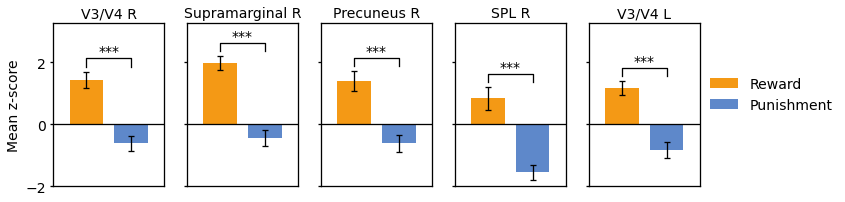

In [20]:
# Manual region labels
cluster_labels_perr_rew_minus_pun = ['V3/V4 R', 'Supramarginal R', 
                                     'Precuneus R', 'SPL R',
                                     'V3/V4 L', 'V1 R', 'Precentral R']

# Figure settings
mpl.rcParams.update({
    'font.size': 14, 
    'axes.titlesize': 14,
    'ytick.major.width': 1.3,
    'lines.linewidth': 1.3,
    'axes.linewidth': 1.3,
    'legend.framealpha': 0,
})

bar_xticks = (0.3, 0.7) 
bar_xlim = (0, 1)
bar_ylim = (-2, 3.25)
bar_width = 0.3
bar_colors = ['#f49915', '#5E88CA']
bar_bracket_offset = 0.03 

fig_legend_position = [1.1, 0.75]
fig_subplots_gap = 0.2 
fig_size = (14, 3)

error_kw = {
    'capsize': 3, 
    'elinewidth': 1.3, 
    'capthick': 1.3,
}

fig, ax = plt.subplots(ncols=6, figsize=fig_size, facecolor='w', sharey=True)

for idx, (df_peak, label) in enumerate(zip(peaks_individual_betas[:5],
                                           cluster_labels_perr_rew_minus_pun[:5])):

    # Calculate paired t-stat and p-value
    tstat = ss.ttest_ind(df_peak['prlrew'], df_peak['prlpun'])
    annotation = '***' if tstat.pvalue < 0.0001 else '?'
    
    ax[idx].bar(
        x=bar_xticks, 
        height=df_peak.mean(),
        width=bar_width,
        color=bar_colors,
        yerr=df_peak.std() / (n_subjects_ok ** (0.5)),
        linewidth=0,
        error_kw=error_kw,
    )
    ax[idx].axhline(0, color='k')
    ax[idx].set_xlim(bar_xlim)
    ax[idx].set_xticks([])
    ax[idx].set_title(label)
    ax[idx].set_ylim(bar_ylim)
    
    barplot_annotate_brackets(
        ax=ax[idx], 
        num1=0, 
        num2=1, 
        text=annotation, 
        center=bar_xticks, 
        height=df_peak.mean(), 
        yerr=df_peak.std() / (n_subjects_ok ** (0.5)),
        dh=bar_bracket_offset
    )

# Add yLabel
firstSubplot = ax[0]
firstSubplot.set_ylabel('Mean z-score')

# Add legend
lastSubplot = ax[-1]
lastSubplot.set_frame_on(False)
lastSubplot.get_xaxis().set_visible(False)
lastSubplot.get_yaxis().set_visible(False)
lastSubplot.legend(
    handles=ax[0].patches, 
    labels=['Reward', 'Punishment'],
    bbox_to_anchor=fig_legend_position,
    
)

plt.subplots_adjust(wspace=fig_subplots_gap)

fig.savefig(
    os.path.join(path_out, 'peaks_perr_rew_minus_pun_alpha_0_001.svg'),
    bbox_inches='tight'
)

In [18]:
plotting.plot_img(
    activations_perr_inc, 
    bg_img=img_mni_09c_clipped,
    display_mode='z',
    cut_coords=(-12, 2, 34, 45, 70),
    threshold=thr_perr_inc,
    vmax=9,
    vmin=-9,
    black_bg=False,
    colorbar=True,
    cmap='cold_hot',
    output_file=os.path.join(path_out, 'spm_perr_alpha_0_0001.svg')
)

In [19]:
plotting.plot_img(
    activations_perr_rew_minus_pun, 
    bg_img=img_mni_09c_clipped,
    display_mode='z',
    cut_coords=(-3, 23, 30, 48, 58),
    threshold=thr_perr_rew_minus_pun,
    black_bg=False,
    colorbar=True,
    vmin=0,
    vmax=9,
    cmap='hot',
    output_file=os.path.join(path_out, 'spm_perr_rew_minus_pun_alpha_0_001.svg')
)